# Clustering Unlabeled Sound Data

## Assignment

Complete the tasks in the notebook and document your observations in the markdown cells.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
#Make allNecessary Imports
import librosa
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [9]:
# Load the Data
unlabelled_data_path = "/content/drive/MyDrive/unlabelled_sounds/unlabelled_sounds"

features = []
#Extract Features
# Initializing the  list to hold features
features = []
file_names = []

# Function to extract mean Mel spectrogram
def extract_mel_features(file_path, sr=22050, n_mels=128):
    y, sr = librosa.load(file_path, sr=sr)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    return np.mean(mel_db, axis=1)  # 1D vector

from tqdm import tqdm

# Looping  through files and extract features
for file in tqdm(os.listdir(unlabelled_data_path)):
    if file.endswith('.wav'):
        path = os.path.join(unlabelled_data_path, file)
        try:
            mel_feat = extract_mel_features(path)
            features.append(mel_feat)
            file_names.append(file)
        except Exception as e:
            print(f"Failed to process {file}: {e}")

# Convert to NumPy array
X = np.array(features)
print(f"Extracted features shape: {X.shape}")

100%|██████████| 3000/3000 [02:00<00:00, 24.82it/s]

Extracted features shape: (3000, 128)


**From the results, our data  have 3000 samples and each sample has 128 features (averaged Mel spectrogram bins).**

# **Scatter plot (Attempt without dimensionality reduction) plus Pair plot**

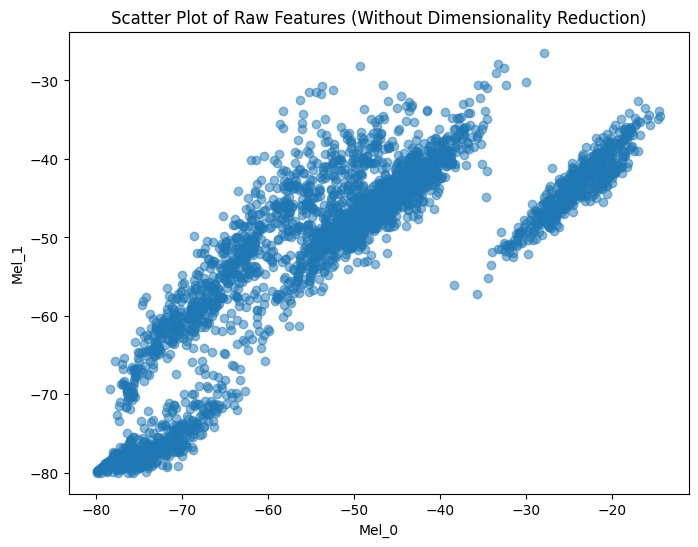

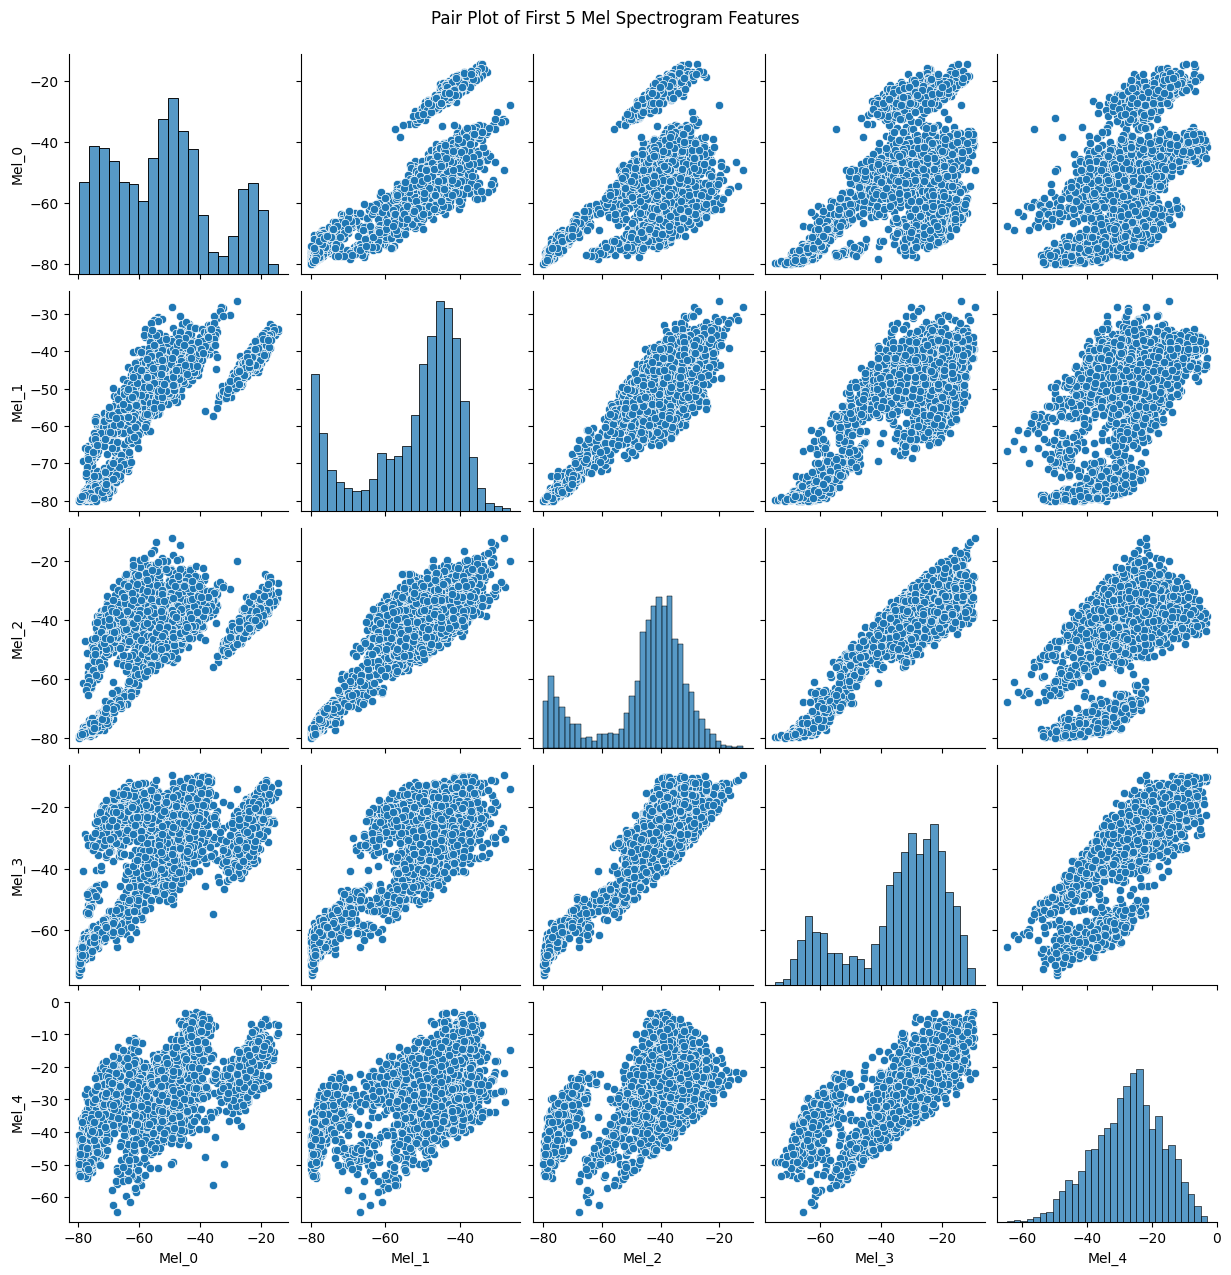

In [13]:
# Generating feature names
feature_names = [f"Mel_{i}" for i in range(X.shape[1])]

# Creating DataFrame using the first 5 Mel features
df = pd.DataFrame(X[:, :5], columns=feature_names[:5])

# Scatter plot using first two features
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], alpha=0.5)
plt.xlabel("Mel_0")
plt.ylabel("Mel_1")
plt.title("Scatter Plot of Raw Features (Without Dimensionality Reduction)")
plt.show()

# Pair plot using first five features
sns.pairplot(df)
plt.suptitle("Pair Plot of First 5 Mel Spectrogram Features", y=1.02)
plt.show()


### Why is dimensionality reduction important?
1. When l tried visualizing the sound data as illustrated above using a scatter plot and a pair plot, the points were jumbled all over with no definite patterns or clear groups . This is because the sound dataset is a 128 dimensional dataset and visualizing a few of these dimensions as l did above (only 5) would result in me ignoring some important relationships which are in the remaining features l could not visualize as they were too many.
2. This challenge of trying to visualize the whole dataset to understand it better  when l have many features (in this case 128) made me realize how plots may become misleading, noisy and unreliable when there is a bigger dimension dataset.
3. This problem is why dimensionality reduction is important, it is a process that allows us to select the most important parts of the large dimension dataset into fewer dimensions that still allows us to visualize , analyze, process and understand the information that the features are conveying.


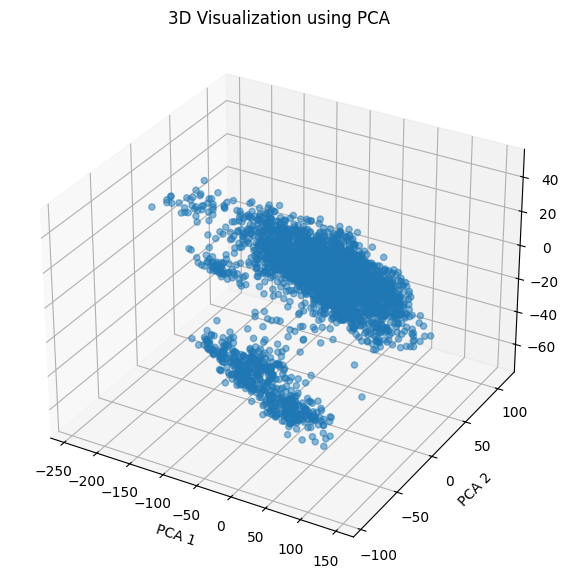

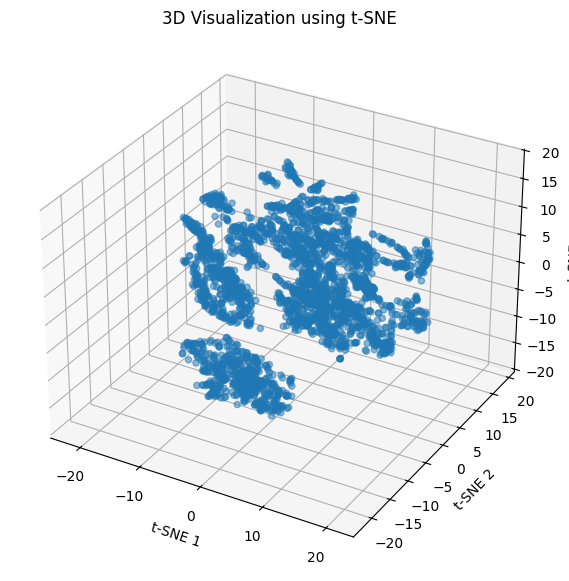

In [15]:

# Apply PCA (3 components)
pca = PCA(n_components=3)
features_pca = pca.fit_transform(X)

# Apply t-SNE (3 components)
tsne = TSNE(n_components=3, perplexity=30, random_state=42)
features_tsne = tsne.fit_transform(X)

# 3D Visualization goes here

# PCA 3D Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2], alpha=0.5)
ax.set_title("3D Visualization using PCA")
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
plt.show()

# t-SNE 3D Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features_tsne[:, 0], features_tsne[:, 1], features_tsne[:, 2], alpha=0.5)
ax.set_title("3D Visualization using t-SNE")
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_zlabel("t-SNE 3")
plt.show()




### Which method (PCA or t-SNE) provides better separability of clusters and why?

**t-SNE Cluster Separability**

From my visualizations above, t-SNE successfully grouped similar datapoints closer together, forming multiple distinct clusters with clear separation. This method excels at preserving local relationships in the data, which helps reveal detailed and meaningful cluster groupings that are easily visible.

**PCA Cluster Separability**

PCA, on the other hand, separated the data to some extent but only showed two distinct clusters clearly. Many datapoints overlapped in the PCA visualization, which buried finer cluster structures and made it harder to distinguish detailed groupings. This is because PCA relies on linear transformations and emphasizes global variance.

**Why t-SNE Performs Better**

Overall, t-SNE works better because it keeps similar points close together, showing groups more clearly even when the data is complicated. PCA uses a linear approach that can miss these small details, so it doesn't show the groups as clearly when the data has complex patterns. From the 3D plots above this is clearly shown .

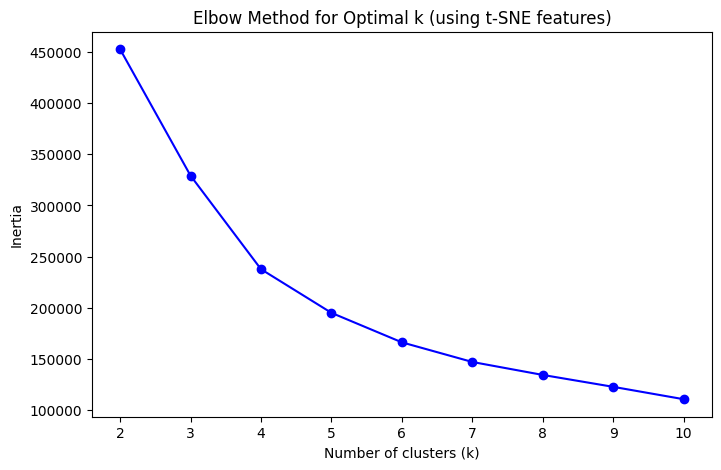

In [17]:

# Optimize number of clusters using Elbow Method

# I will use features_tsne because it was my best
k_values = range(2, 11)
inertia_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_tsne)
    inertia_values.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia_values, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k (using t-SNE features)')
plt.show()




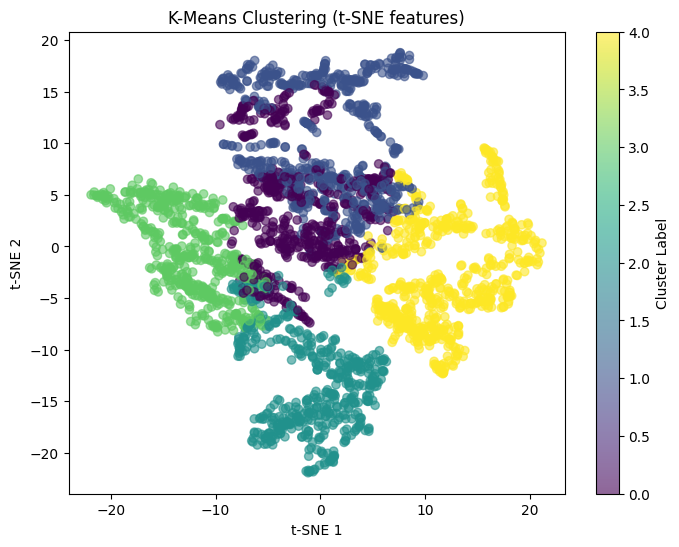

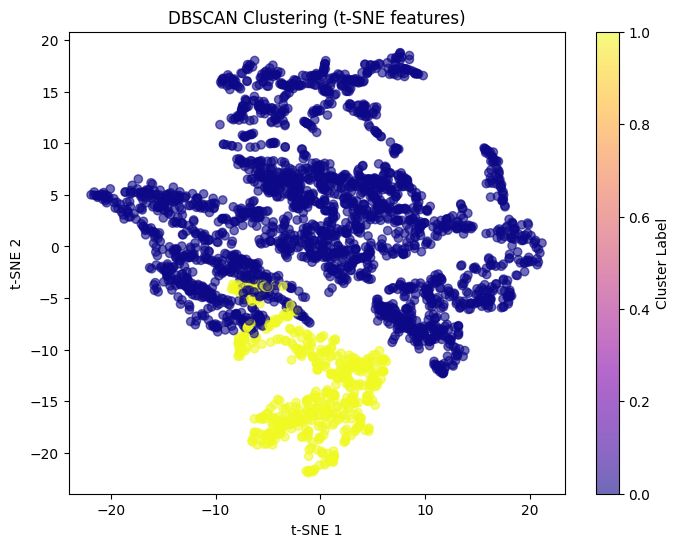

In [21]:
# Select optimal K based on elbow method
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(features_tsne)

# Apply DBSCAN
dbscan = DBSCAN(eps=5, min_samples=3)
dbscan_labels = dbscan.fit_predict(features_tsne)

# Scatter Plot for K-Means Clusters
plt.figure(figsize=(8, 6))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.6)
plt.title("K-Means Clustering (t-SNE features)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar(label='Cluster Label')
plt.show()

# Scatter Plot for DBSCAN Clusters
plt.figure(figsize=(8, 6))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=dbscan_labels, cmap='plasma', alpha=0.6)
plt.title("DBSCAN Clustering (t-SNE features)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar(label='Cluster Label')
plt.show()

In [23]:
# Evaluate clustering
kmeans_silhouette = silhouette_score(features_tsne, kmeans_labels)
kmeans_db_index = davies_bouldin_score(features_tsne, kmeans_labels)

if len(set(dbscan_labels)) > 1:
    dbscan_silhouette = silhouette_score(features_tsne, dbscan_labels)
    dbscan_db_index = davies_bouldin_score(features_tsne, dbscan_labels)
else:
    dbscan_silhouette = None
    dbscan_db_index = None

print(f"K-Means - Silhouette Score: {kmeans_silhouette:.4f}, Davies-Bouldin Index: {kmeans_db_index:.4f}")
if dbscan_silhouette is not None:
    print(f"DBSCAN - Silhouette Score: {dbscan_silhouette:.4f}, Davies-Bouldin Index: {dbscan_db_index:.4f}")
else:
    print("DBSCAN failed to form meaningful clusters.")

K-Means - Silhouette Score: 0.3632, Davies-Bouldin Index: 0.9808
DBSCAN - Silhouette Score: 0.2876, Davies-Bouldin Index: 1.0922



### Discuss the results (max 5 lines)

I used t-SNE-reduced features for clustering since they gave better visual separation. K-Means produced a silhouette score of 0.3632 and a Davies-Bouldin Index of 0.9808, showing fairly good and compact clusters. DBSCAN performed worse with a lower silhouette score of 0.2876 and a higher DB index of 1.0922, indicating more overlap and weaker cluster definition. While DBSCAN is suited for arbitrary shapes, K-Means worked better here. Based on both metrics and visual output, K-Means provided better clustering results.






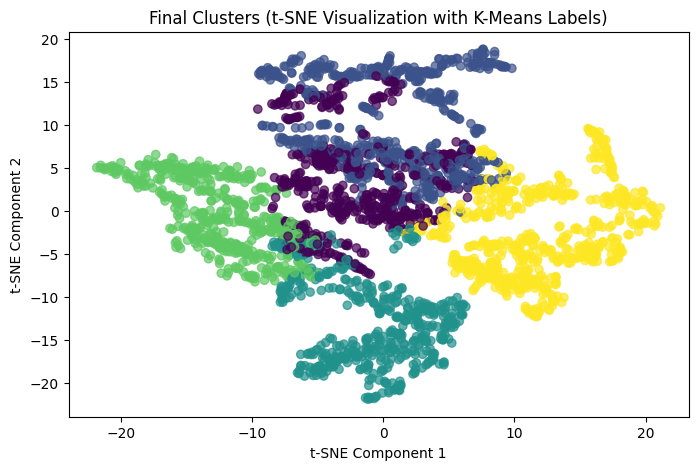

In [24]:

# Final visualization using t-SNE
plt.figure(figsize=(8, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Final Clusters (t-SNE Visualization with K-Means Labels)")
plt.show()


### Final Analysis
**- Explain why dimensionality reduction helped (or didn't) in clustering.**

From this large dimension sound dataset, dimensionality reduction definitely helped in clustering . It  compressed our 128 dimension dataset into a lower dimensional space that still preserved local relationships . As a result,the visualizations were able to show more distinct clusters which were easier to understand.

**- Justify why certain clustering methods worked better.**

The scatter plots from the clustering visualization cells also showed K-Means producing clearer and more distinct clusters, while DBSCAN’s clusters appeared less defined and more overlapping. This suggests that K-Means’ assumption of spherical and evenly sized clusters aligns better with the cluster structure revealed by t-SNE, whereas DBSCAN’s density-based approach was less effective due to the uniform distribution and lack of noise in the data.

**- Relate findings to real-world clustering challenges.**

Clustering real-world data like sound recordings is often hard because the data has many features, can be noisy, and complicated. Using dimensionality reduction methods like t-SNE helps by reducing noise and showing important patterns more clearly, making clustering easier and more accurate.


Choosing the right clustering method is also important. K-Means works well when groups are clear and round-shaped, but it may struggle with noisy or irregular data. DBSCAN can find unusual or irregular groups but needs careful tuning and may not work well if the data does not have obvious differences in density. For example, in marketing, K-Means is used to group similar customers, while DBSCAN helps find rare or unusual buying behaviors. This shows why combining dimensionality reduction with the right clustering approach and visual checks is key in solving real-world problems.